# Assignment 1 - Solution

In [1]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective
from optimization.optimization_data import OptimizationData
from optimization.quadratic_program import QuadraticProgram, ALL_SOLVERS

## 1. Solver horse race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [2]:

# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

# Generate a random mean vector and covariance matrix for the multivariate normal distribution
mean = np.random.randn(N)
cov = np.random.randn(N, N)
cov = (cov + cov.T) / 2  # Ensure symmetry

# Generate the Multivariate-Normal random dataset
data = np.random.multivariate_normal(mean, cov, T) / 100
data = np.exp(data) - 1  # Convert to discrete returns

# Convert the dataset to a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns)
q = ExpectedReturn(method='geometric').estimate(df, inplace=False)

# Compute the covariance matrix
P = Covariance(method='pearson').estimate(df, inplace=False)

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)

Vector of expected returns (q):
Asset_1     -0.002070
Asset_2     -0.004787
Asset_3      0.006558
Asset_4      0.002403
Asset_5     -0.003201
               ...   
Asset_96    -0.001385
Asset_97    -0.032548
Asset_98     0.002426
Asset_99    -0.018850
Asset_100    0.005649
Length: 100, dtype: float64

Covariance matrix (P):
            Asset_1   Asset_2       Asset_3   Asset_4       Asset_5   Asset_6  \
Asset_1    0.000502  0.000094 -2.931778e-05 -0.000019  3.326873e-05 -0.000030   
Asset_2    0.000094  0.000611  9.743107e-05  0.000024  2.475752e-05 -0.000045   
Asset_3   -0.000029  0.000097  6.679712e-04  0.000028 -4.311214e-08 -0.000038   
Asset_4   -0.000019  0.000024  2.847601e-05  0.000608 -6.150617e-05 -0.000062   
Asset_5    0.000033  0.000025 -4.311214e-08 -0.000062  5.241147e-04 -0.000001   
...             ...       ...           ...       ...           ...       ...   
Asset_96   0.000013 -0.000050 -4.913882e-05  0.000001  6.843613e-05  0.000016   
Asset_97   0.000007  0.000

C:\Users\admin\AppData\Local\Temp\ipykernel_1628\2779574715.py:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  data = np.random.multivariate_normal(mean, cov, T) / 100


### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [3]:
# Instantiate the Constraints class
constraints = Constraints(ids = df.columns.tolist())

# Add budget constraint
constraints.add_budget(rhs=1, sense='=')

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(lower=0, upper=0.2)

# Add linear constraints
G = pd.DataFrame(np.zeros((3, N)), columns=constraints.ids)
G.iloc[0, 0:30] = 1
G.iloc[1, 30:60] = 1
G.iloc[2, 60:100] = 1
h = pd.Series([0.3, 0.4, 0.5])
constraints.add_linear(G=G, sense='<=', rhs=h)

constraints

### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution).

In [ ]:
# Extract the constraints in the format required by the solver
GhAb = constraints.to_GhAb()

# Instantiate the optimization problem
risk_aversion = 2

result_on_fail =  {
    'solution_found': False,
    'objective_builtin': np.nan,
    'primal_residual': np.nan,
    'dual_residual' : np.nan,
    'duality_gap': np.nan,
    'runtime': np.nan,
}
result_dict = {}
weights_dict = {}
for solver_name in ALL_SOLVERS:
    
    try:
        qp = QuadraticProgram(
            P = P.to_numpy() * risk_aversion,
            q = q.to_numpy() * -1,
            G = GhAb['G'],
            h = GhAb['h'],
            A = GhAb['A'],
            b = GhAb['b'],
            lb = constraints.box['lower'].to_numpy(),
            ub = constraints.box['upper'].to_numpy(),
            solver = solver_name,
        )
        
        # Measure the runtime of qp.solve() using timeit
        runtime = timeit.timeit(lambda: qp.solve(), number=1)

        solution = qp.results['solution']
        if solution.found:
            result =  {
                'solution_found' : solution.found,
                'objective_builtin' : solution.obj,
                'primal_residual' :solution.primal_residual(),
                'dual_residual' : solution.dual_residual(),
                'duality_gap' : solution.duality_gap()[0],
                'runtime' : runtime
            }
            result_dict[solver_name] = result
            weights_dict[solver_name] = pd.Series(solution.x, df.columns)
        
    except Exception as e:
        print(f"Solver {solver_name} failed: {e}")
        result_dict[solver_name] = result_on_fail

Solver clarabel failed: Solver 'clarabel' is not available. Choose from: {'quadprog', 'daqp', 'qpalm', 'highs', 'osqp', 'cvxopt'}
Solver ecos failed: Solver 'ecos' is not available. Choose from: {'quadprog', 'daqp', 'qpalm', 'highs', 'osqp', 'cvxopt'}
Solver gurobi failed: Solver 'gurobi' is not available. Choose from: {'quadprog', 'daqp', 'qpalm', 'highs', 'osqp', 'cvxopt'}
Solver mosek failed: Solver 'mosek' is not available. Choose from: {'quadprog', 'daqp', 'qpalm', 'highs', 'osqp', 'cvxopt'}
Solver piqp failed: Solver 'piqp' is not available. Choose from: {'quadprog', 'daqp', 'qpalm', 'highs', 'osqp', 'cvxopt'}
Solver scs failed: Solver 'scs' is not available. Choose from: {'quadprog', 'daqp', 'qpalm', 'highs', 'osqp', 'cvxopt'}
Solver proxqp failed: Solver 'proxqp' is not available. Choose from: {'quadprog', 'daqp', 'qpalm', 'highs', 'osqp', 'cvxopt'}


Print and visualize the results

In [5]:
results_df = pd.DataFrame(result_dict)
results_df

,quadprog,clarabel,ecos,daqp,gurobi,mosek,piqp,qpalm,scs,highs,osqp,proxqp,cvxopt
solution_found,True,False,False,True,False,False,False,True,False,True,True,False,True
objective_builtin,-0.016071,NaN,NaN,-0.016071,NaN,NaN,NaN,None,NaN,None,None,NaN,-0.016071
primal_residual,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.00005,NaN,0.0,0.000074,NaN,0.0
dual_residual,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.000001,NaN,0.0
duality_gap,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.00005,NaN,0.0,0.000031,NaN,0.0
runtime,0.011188,NaN,NaN,0.005681,NaN,NaN,NaN,0.012493,NaN,0.0066,0.005866,NaN,0.049841


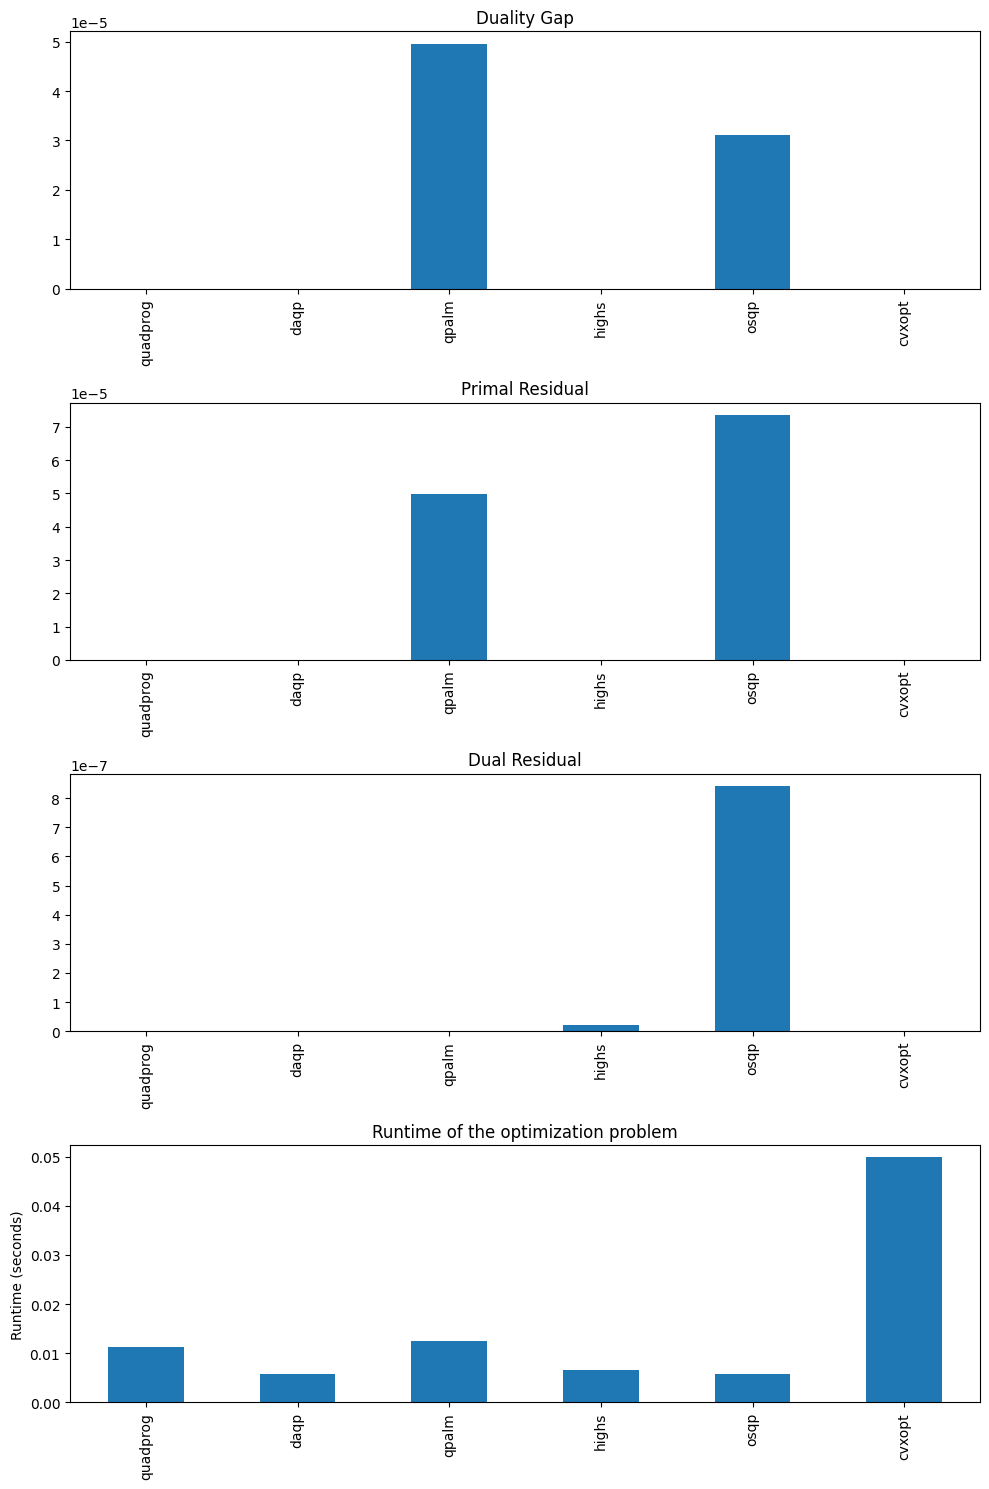

In [6]:
# Extract names of solvers which found a solution
sol_found = results_df.columns[results_df.loc['solution_found'] == True]

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

# Plot runtimes
results_df.loc['runtime', sol_found].plot(kind='bar', title='Runtime of the optimization problem', ylabel='Runtime (seconds)')

# Plot duality gap
results_df.loc['duality_gap', sol_found].plot(kind='bar', ax=axes[0], title='Duality Gap')

# Plot primal residual
results_df.loc['primal_residual', sol_found].plot(kind='bar', ax=axes[1], title='Primal Residual')

# Plot dual residual
results_df.loc['dual_residual', sol_found].plot(kind='bar', ax=axes[2], title='Dual Residual')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).

<Axes: title={'center': 'Analytical portfolio weights'}, ylabel='Weight'>

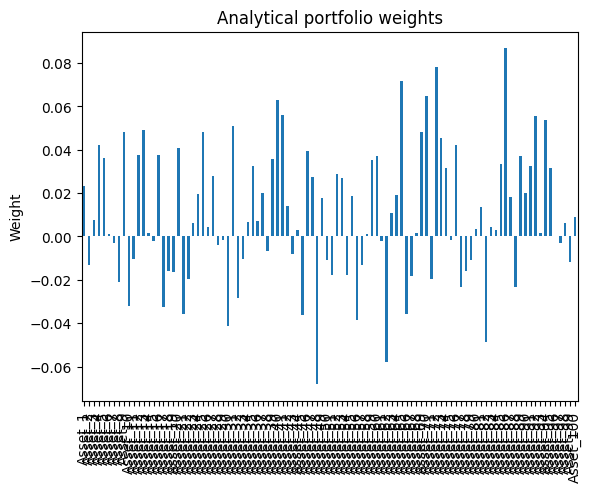

In [7]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        X = optimization_data['return_series']
        covmat = self.covariance.estimate(X=X, inplace=False)
        mu = np.zeros(X.shape[1])
        self.objective = Objective(
            q = mu ,
            P = covmat * 2,
        )
        return None

    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            GhAb = self.constraints.to_GhAb()
            if GhAb['G'] is not None:
                raise ValueError(
                    'Analytical solution does not exist whith inequality constraints.'
                )
            A = GhAb['A']
            b = GhAb['b']
            # If b is scalar, convert it to a 1D array
            if isinstance(b, (int, float)):
                b = np.array([b])
            elif b.ndim == 0:
                b = np.array([b])

            P = self.objective.coefficients['P']
            P_inv = np.linalg.inv(P)

            AP_invA = A @ P_inv @ A.T
            if AP_invA.shape[0] > 1:
                AP_invA_inv = np.linalg.inv(AP_invA)
            else:
                AP_invA_inv = 1 / AP_invA
            x = pd.Series(P_inv @ A.T @ AP_invA_inv @ b,
                          index=self.constraints.ids)      
            self.results.update({
                'weights': x.to_dict(),
                'status': True,
            })
            return None
        else:
            return super().solve()
    

# Create a constraints object with just a budget constraint
constraints = Constraints(ids=df.columns.tolist())
constraints.add_budget(rhs=1, sense='=')

# Instantiate the MinVariance class
mv = MinVariance(
    constraints = constraints,
    covariance = Covariance(method='pearson'),
    risk_aversion = risk_aversion,
    solver_name = 'analytical'
)

# Prepare the optimization data and prepare the optimization problem
optimization_data = OptimizationData(return_series = df)
mv.set_objective(optimization_data=optimization_data)

# Solve the optimization problem and compare the weights to solutions obtained in 1.c).
mv.solve()
weights_analytical = pd.Series(mv.results['weights'])

# weights_df = pd.concat({
#     **weights_dict,
#     'analytical': weights_analytical
# }, axis=1)
# weights_df.plot(kind='bar', title='Portfolio weights', ylabel='Weight')
weights_analytical.plot(kind='bar', title='Analytical portfolio weights', ylabel='Weight')

